## Loading the Dataset

#### Import necessary libraries

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Load the CSV file (Animation_Movies.csv)

In [181]:
file_path = 'data/Animation_Movies.csv'
df = pd.read_csv(file_path)
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,150540,Inside Out,7.922,19463,Released,2015-06-09,857611174,95,False,/j29ekbcLpBvxnGk6LjdTc2EI5SA.jpg,...,en,Inside Out,"Growing up can be a bumpy road, and it's no ex...",107.292,/2H1TmgdfNtsKlU9jKdeNyYL5y8T.jpg,Meet the little voices inside your head.,"Animation, Family, Adventure, Drama, Comedy","Pixar, Walt Disney Pictures",United States of America,English
1,14160,Up,7.949,18857,Released,2009-05-28,735099082,96,False,/hGGC9gKo7CFE3fW07RA587e5kol.jpg,...,en,Up,Carl Fredricksen spent his entire life dreamin...,90.968,/vpbaStTMt8qqXaEgnOR2EE4DNJk.jpg,The greatest adventure is just getting back home.,"Animation, Comedy, Family, Adventure",Pixar,United States of America,English
2,12,Finding Nemo,7.824,18061,Released,2003-05-30,940335536,100,False,/h3uqFk7sZRJvLZDdLiFB9qwbL07.jpg,...,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",55.456,/ggQ6o8X5984OCh3kZi2UIJQJY5y.jpg,There are 3.7 trillion fish in the ocean. They...,"Animation, Family",Pixar,United States of America,English
3,354912,Coco,8.222,17742,Released,2017-10-27,800526015,105,False,/askg3SMvhqEl4OL52YuvdtY40Yb.jpg,...,en,Coco,Despite his family’s baffling generations-old ...,166.578,/gGEsBPAijhVUFoiNpgZXqRVWJt2.jpg,The celebration of a lifetime,"Family, Animation, Fantasy, Music, Comedy, Adv...","Pixar, Walt Disney Pictures",United States of America,"English, Spanish"
4,10681,WALL·E,8.078,17446,Released,2008-06-22,521311860,98,False,/fK5ssgvtI43z19FoWigdlqgpLRE.jpg,...,en,WALL·E,What if mankind had to leave Earth and somebod...,58.517,/hbhFnRzzg6ZDmm8YAmxBnQpQIPh.jpg,After 700 years of doing what he was built for...,"Animation, Family, Science Fiction","Pixar, Walt Disney Pictures",United States of America,English


#### structure of data

In [182]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51945 entries, 0 to 51944
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    51945 non-null  int64  
 1   title                 51944 non-null  object 
 2   vote_average          51945 non-null  float64
 3   vote_count            51945 non-null  int64  
 4   status                51945 non-null  object 
 5   release_date          49808 non-null  object 
 6   revenue               51945 non-null  int64  
 7   runtime               51945 non-null  int64  
 8   adult                 51945 non-null  bool   
 9   backdrop_path         15835 non-null  object 
 10  budget                51945 non-null  int64  
 11  homepage              8253 non-null   object 
 12  imdb_id               29552 non-null  object 
 13  original_language     51945 non-null  object 
 14  original_title        51944 non-null  object 
 15  overview           

,id,vote_average,vote_count,revenue,runtime,budget,popularity
count,5.194500e+04,51945.000000,51945.000000,5.194500e+04,51945.000000,5.194500e+04,51945.000000
mean,6.188122e+05,2.597083,40.395380,1.863464e+06,20.901415,5.759513e+05,1.886233
std,3.479748e+05,3.318748,482.705948,3.049824e+07,39.016002,7.606628e+06,9.700913
min,1.200000e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,3.300810e+05,0.000000,0.000000,0.000000e+00,3.000000,0.000000e+00,0.600000
50%,6.119150e+05,0.000000,0.000000,0.000000e+00,7.000000,0.000000e+00,0.600000
75%,9.159040e+05,6.000000,2.000000,0.000000e+00,19.000000,0.000000e+00,0.882000
max,1.238314e+06,10.000000,19463.000000,1.450027e+09,3720.000000,2.600000e+08,1008.942000


#### function to compute the required statistics

In [183]:
def feature_statistics(func_df, feature):
    feature_data = func_df[feature].dropna()
    feature_type = feature_data.dtype
    feature_range = feature_data.max() - feature_data.min()
    feature_min = feature_data.min()
    feature_max = feature_data.max()
    feature_mean = feature_data.mean()
    feature_mode = feature_data.mode()[0] if not feature_data.mode().empty else None
    feature_median = feature_data.median()

    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]

    return {
        "Feature": feature,
        "Type": feature_type,
        "Range": feature_range,
        "Min": feature_min,
        "Max": feature_max,
        "Mean": feature_mean,
        "Mode": feature_mode,
        "Median": feature_median,
        "Outliers": outliers
    }

#### Handle Missing Values

In [184]:
numerical_features = ['runtime', 'vote_count', 'vote_average', 'budget', 'revenue']

# Generate the table for each feature
feature_stats = [feature_statistics(df, feature) for feature in numerical_features]

# Convert the statistics into a DataFrame for better readability
stats_df = pd.DataFrame(feature_stats)

stats_df

,Feature,Type,Range,Min,Max,Mean,Mode,Median,Outliers
0,runtime,int64,3.720000e+03,0.0,3.720000e+03,2.090141e+01,0.0,7.0,0 95 1 96 2 100 3 ...
1,vote_count,int64,1.946300e+04,0.0,1.946300e+04,4.039538e+01,0.0,0.0,0 19463 1 18857 2 18061 3 ...
2,vote_average,float64,1.000000e+01,0.0,1.000000e+01,2.597083e+00,0.0,0.0,"Series([], Name: vote_average, dtype: float64)"
3,budget,int64,2.600000e+08,0.0,2.600000e+08,5.759513e+05,0.0,0.0,0 175000000 1 175000000 2 ...
4,revenue,int64,1.450027e+09,0.0,1.450027e+09,1.863464e+06,0.0,0.0,0 857611174 1 735099082 2 ...


#### Draw box plots for each feature and highlight outliers

In [185]:
def plot_boxplot(func_df, feature):
    feature_data = func_df[feature].dropna()
    if feature in ['budget', 'revenue']:
        feature_data = feature_data[feature_data > 0]  # Remove zero or negative values
    
    # Calculate IQR
    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    extendCoefficient = 2
    if feature == 'vote_average':
        extendCoefficient = 0

    extended_upper_bound = upper_bound + extendCoefficient * IQR  

    plt.figure(figsize=(16, 8))
    
    sns.boxplot(x=feature_data, color="skyblue", width=0.4)
    plt.title(f'Box plot of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Value', fontsize=14)
    
    plt.xlim(-1, extended_upper_bound)
    
    plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
    
    plt.show()

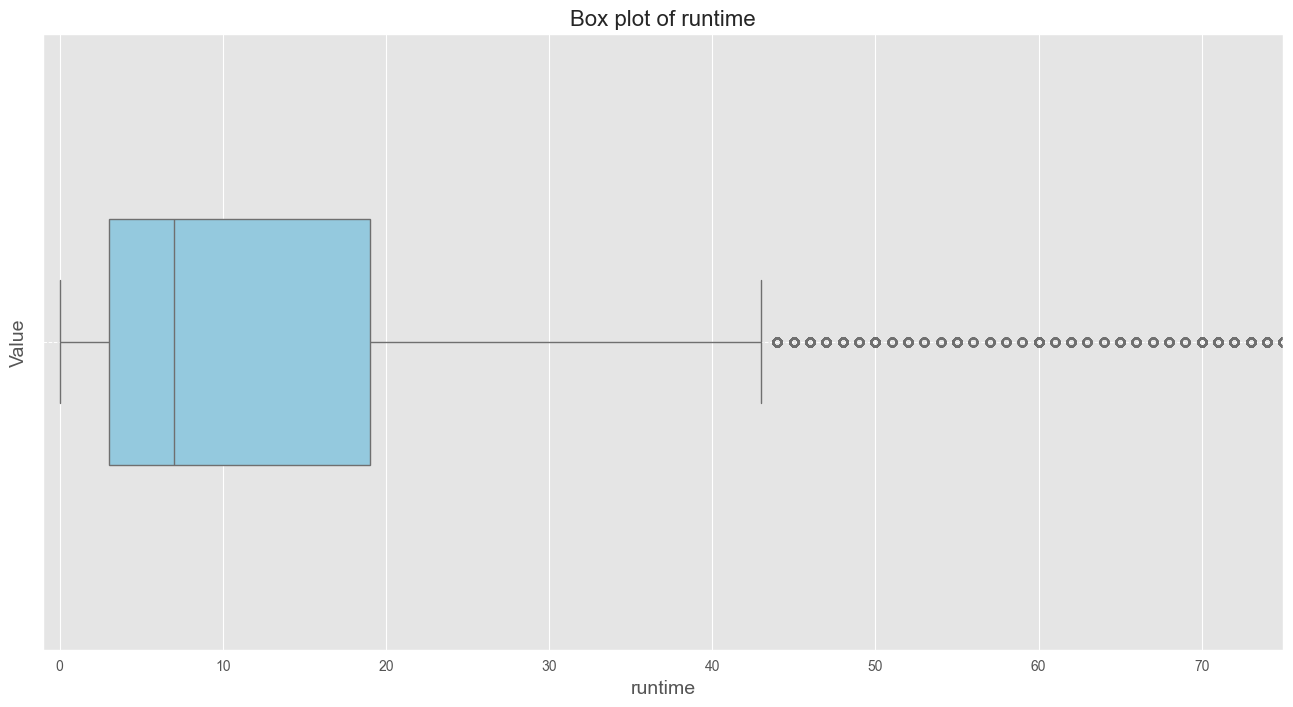

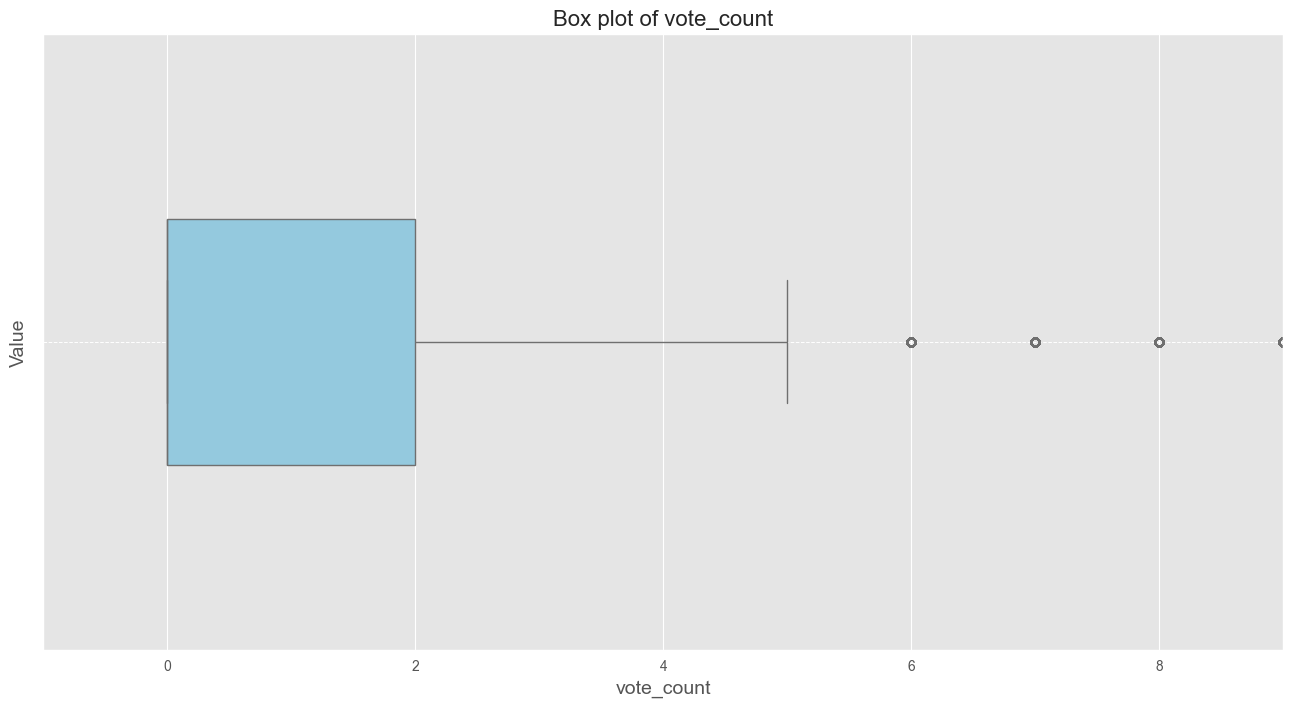

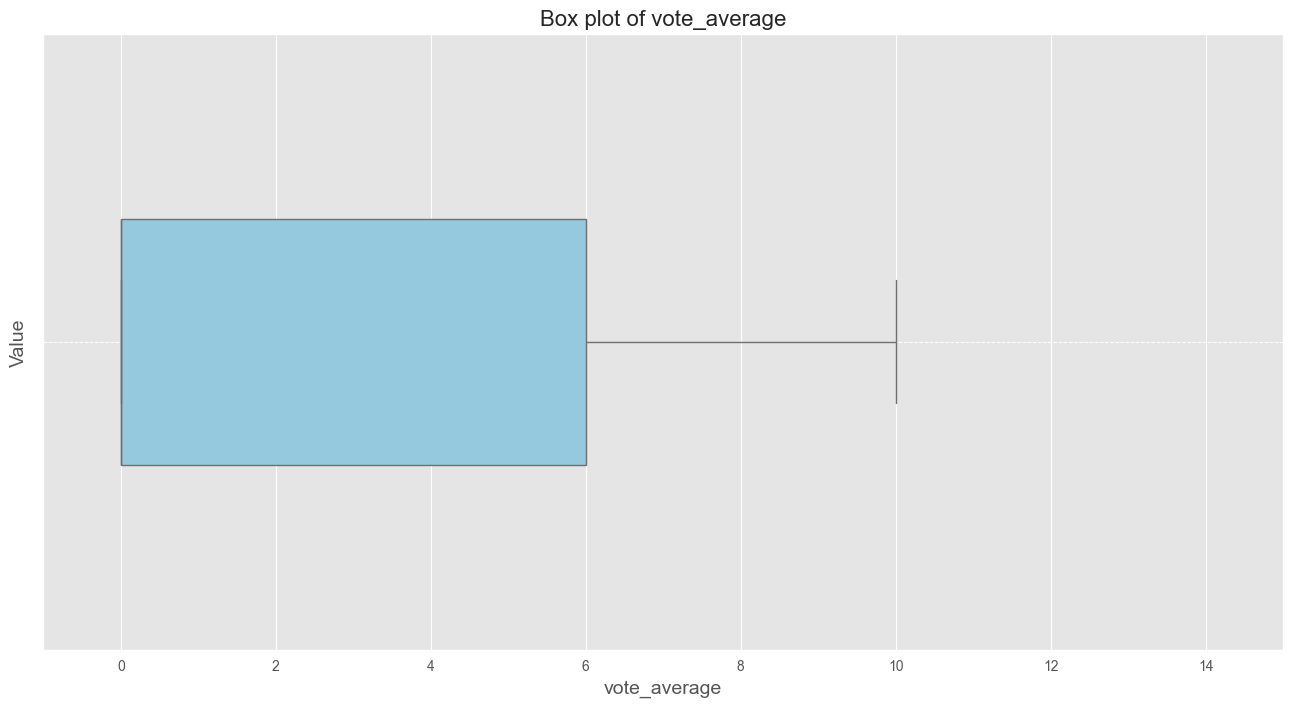

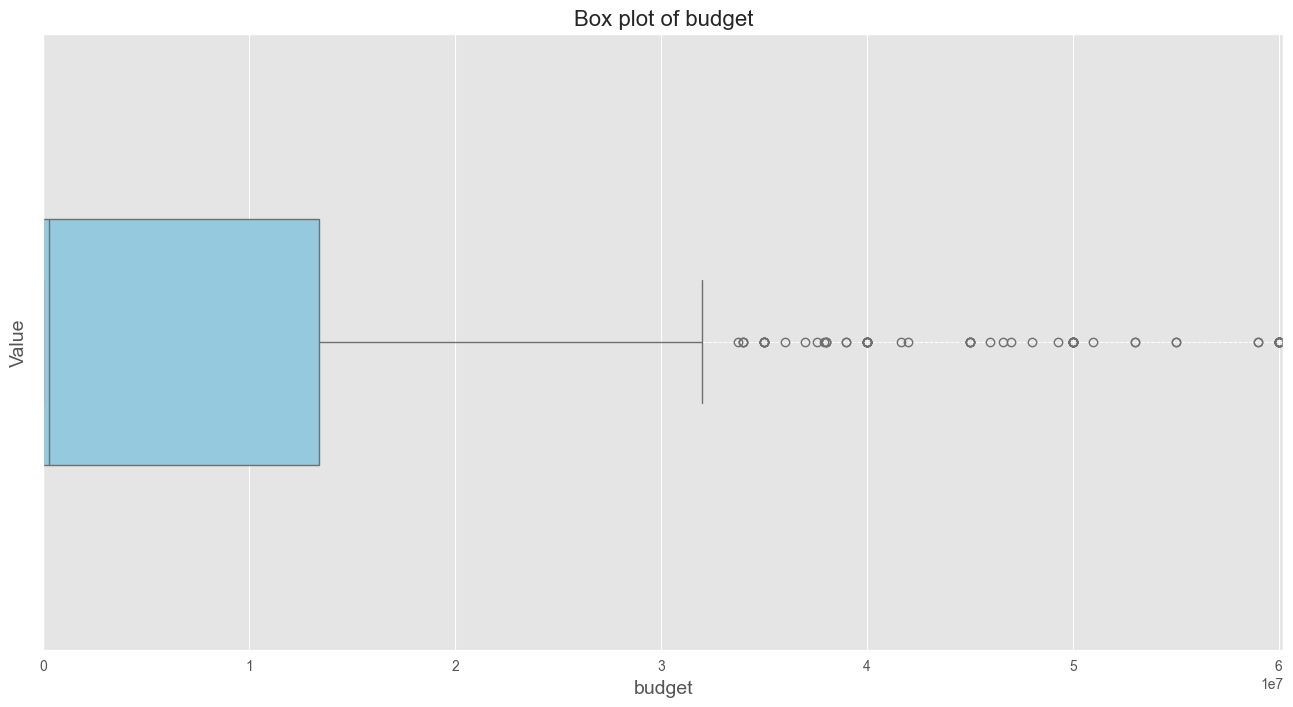

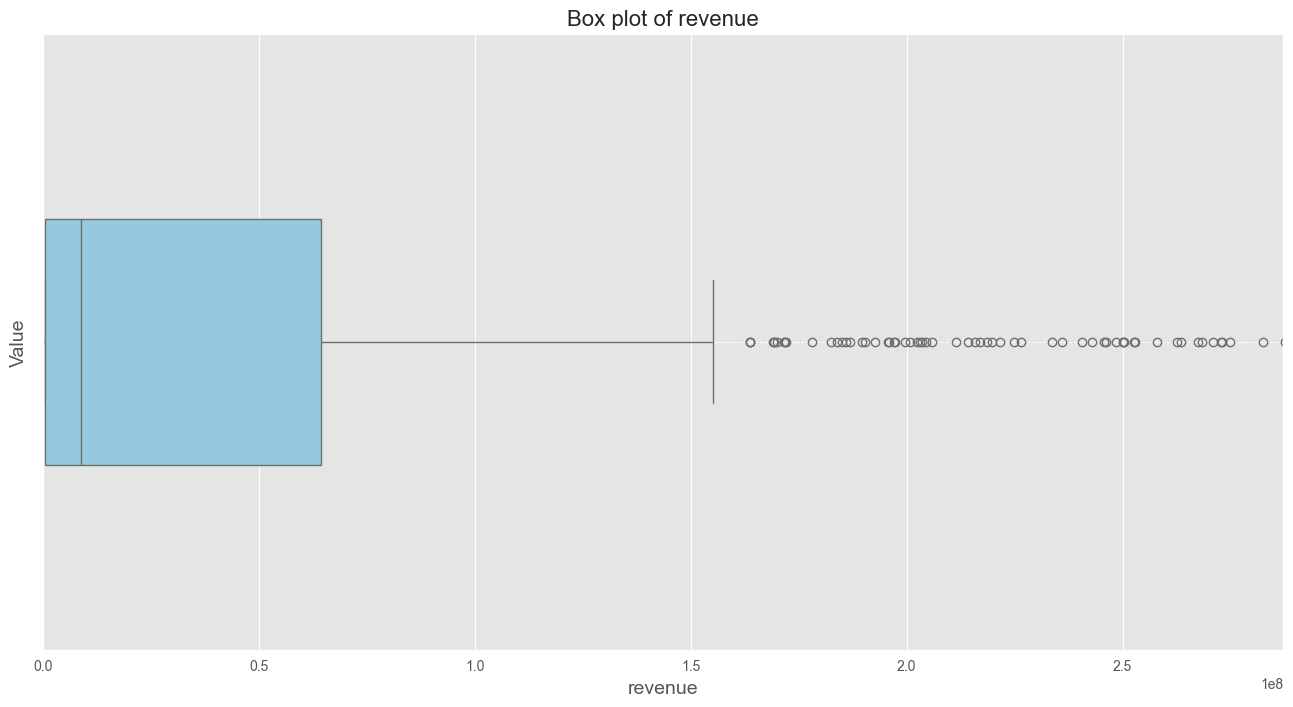

In [186]:
for feature in numerical_features:
    plot_boxplot(df, feature)

#### Filter out rows with missing or zero budget and revenue values

In [187]:
filtered_df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

#### Scatter plot to visualize budget vs revenue

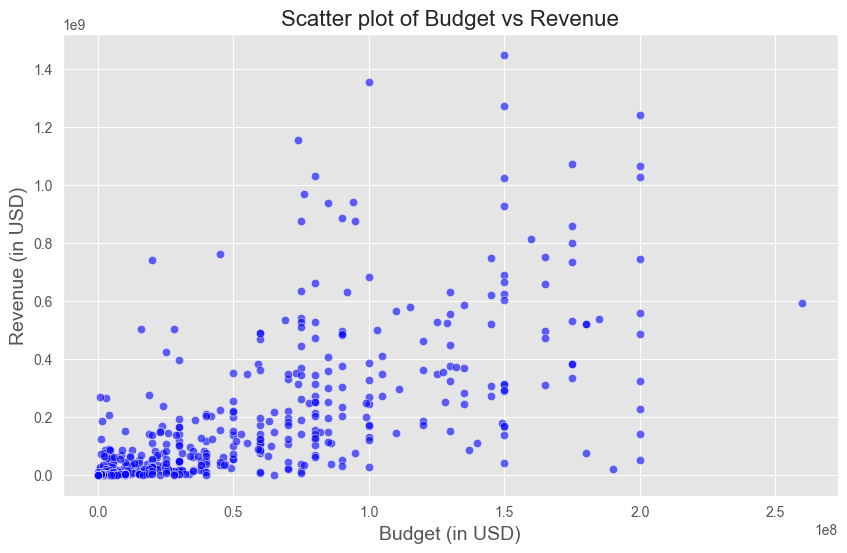

In [188]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='budget', y='revenue', data=filtered_df, color='blue', alpha=0.6)

plt.title('Scatter plot of Budget vs Revenue', fontsize=16)
plt.xlabel('Budget (in USD)', fontsize=14)
plt.ylabel('Revenue (in USD)', fontsize=14)
plt.grid(True)

#### Add a trendline to see the relationship better (regression line)

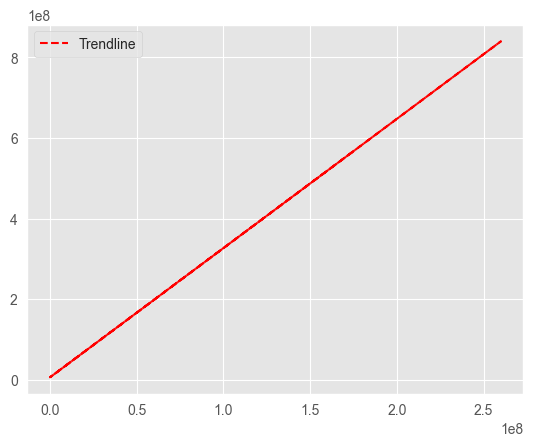

In [189]:
z = np.polyfit(filtered_df['budget'], filtered_df['revenue'], 1)
p = np.poly1d(z)

plt.plot(filtered_df['budget'], p(filtered_df['budget']), "r--", label='Trendline')
plt.legend()
plt.show()

#### Logarithmic Scatter Plot for better scaling

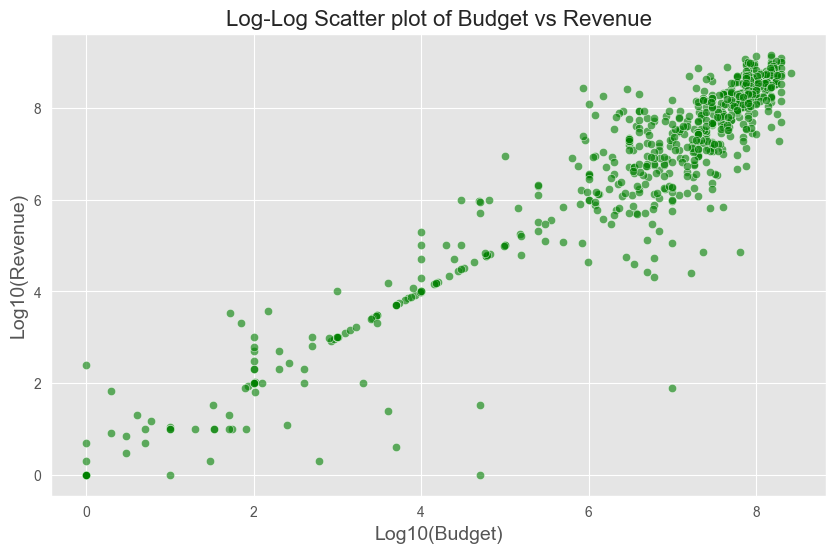

In [190]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.log10(filtered_df['budget']), y=np.log10(filtered_df['revenue']), color='green', alpha=0.6)

# Add labels and title
plt.title('Log-Log Scatter plot of Budget vs Revenue', fontsize=16)
plt.xlabel('Log10(Budget)', fontsize=14)
plt.ylabel('Log10(Revenue)', fontsize=14)
plt.grid(True)
plt.show()